# Testing 2 Techniques for Global Model Explainability

Model explainability (XAI) is growing trend within artificial intelligence and machine learning. For certain industries like finance and healthcare, it is critically important to be able to explain both: 

* why models make the predictions that they do? (**Local Explainability**)
* how the model functions in a holistic sense? (**Global Explainability**)

A popular package for XAI is **SHAP** (https://arxiv.org/abs/1705.07874), however this package focuses on explainability for individual model predictions. This addresses point 1. above, but what are we to do for global explainability?

*Global Model Explainability* refers to understanding what drives the models decisions over an entire data generation process, not just an individual prediction. This translates to being able to quantify how the input predictor features are affecting the models predictions overall.

In this notebook, we'll cover 2 different approaches for tackling global explainability. These will include:

1. compute the aforementioned SHAP values for each sample in our dataset, and sum their magnitudes
2. make use of Shapley Additive Global importance (**SAGE**) (https://arxiv.org/abs/2004.00668) - an algorithm designed to handle the problem of global explainability

Formally, SHAP values $\phi$ approximate the contribution of feature $j$ to the prediction for a specific sample $x$, with respect to the models expected output. When we sum these values over all samples in a dataset we get:

$$\text{Global Importance}_j = \sum_x|\phi_j(x)|$$

This is a heuristic aggregation of local contributions, not a well-defined global metric. It answers a question like:
“*On average, how much does feature $j$ matter for individual predictions?*”

SAGE was introduced to explicitly define a global Shapley framework for feature importance, derived from model performance degradation. It defines a value function $v(S)$ that measures how well the model performs when only a subset of features $S$
is available. 

For example, set $v(S) = \text{Performance}(f_S)$, where $f_S$ is our model with $S$ features known. Then the SAGE value is simply the Shapley value for $v$:

$$\phi_j = E_{S \subseteq D\ \{j\} }[v(S \cup \{j\}) - v(S)]$$

where $D$ is the total set of features available. SAGE answers the question: “*How much does each feature contribute to the model’s predictive performance, averaged over all possible feature subsets?*”

## Setup

Start by importing the required packages for this experiment:

In [1]:
# import
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap
import sage

## Regression Tests

We will work with a simple toy regression dataset below. Our aim is to demonstrate some of the properties of the two aforementioned approaches to global explainability. 

### Create Dataset

Let's setup a simple dataset involving 3 features ($X1$, $X2$, $X3$), 2 of which are informative ($X1$, $X2$). 

In [2]:
# simple dataset of 10000 samples
n_samples = 10000
random_state = 42
rng = np.random.RandomState(random_state)

X1 = rng.normal(0, 1, n_samples)
X2 = rng.normal(0, 1.5, n_samples)
X3 = rng.normal(0, 1, n_samples)
y = 1.5 * X1 + 2 * X2 + rng.normal(0, 0.5, n_samples)

X = np.vstack([X1, X2, X3]).T
feature_names = ["X1", "X2", "X3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

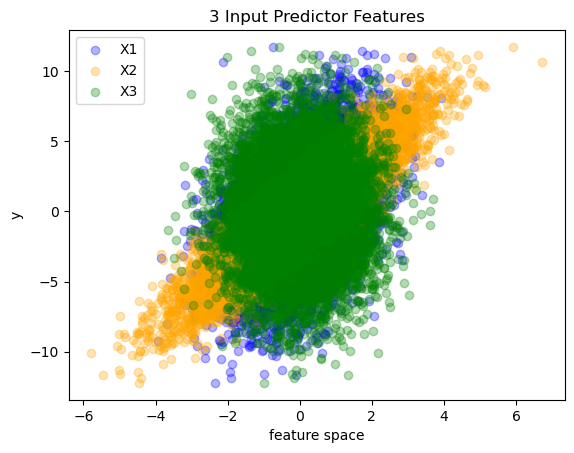

In [14]:
# visualize the results
plt.scatter(X1, y, label="X1", color="blue", alpha=0.3)
plt.scatter(X2, y, label="X2", color="orange", alpha=0.3)
plt.scatter(X3, y, label="X3", color="green", alpha=0.3)
plt.legend()
plt.xlabel('feature space')
plt.ylabel('y')
plt.title('3 Input Predictor Features')
plt.show()

The distribution of data points illustrates the relative correlation between the target ($y$) and each of the individual features. Note that X3 is completely symmetric about $x = 0$, highlighting the fact that this feature is uninformative.

### Build Models

We can try out 2 algorithms for the modelling task, *linear regression* and *random forest*: 

In [15]:
# declare and train model instances
rf = RandomForestRegressor(random_state=random_state)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

print("Linear Regression Test RMSE:", np.sqrt(mean_squared_error(y_test, lr.predict(X_test))))
print("Random Forest Test RMSE:", np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

Linear Regression Test RMSE: 0.5088308581798484
Random Forest Test RMSE: 0.553364515516271


We can see that the linear regression performs better on the test set, which should not be surprising given that the true underlying relationship is linear. 

### Explainability Logic

Now let's try out our 2 approaches for global explainability. To make things a bit more interesting, let's modify the test set such that the sign for all the values for $X2$ are reversed. *The consequence for this will be that this feature will drive the model towards making mistakes*:

In [16]:
# reverse sign for X2 in test set
X_test[:,1] *= -1

In [17]:
%%time

# setup SHAP explainers
explainer = shap.Explainer(lr, X_train)
lr_shap_values = explainer(X_test)
explainer = shap.TreeExplainer(rf, X_train)
rf_shap_values = explainer(X_test)

# Aggregate to get global importances
shap_importance = np.mean(np.abs(lr_shap_values.values), axis=0)
lr_shap_rank = pd.Series(shap_importance, index=feature_names).sort_values(ascending=False)
shap_importance = np.mean(np.abs(rf_shap_values.values), axis=0)
rf_shap_rank = pd.Series(shap_importance, index=feature_names).sort_values(ascending=False)

 97%|=================== | 1945/2000 [00:22<00:00]       

CPU times: user 21.9 s, sys: 55.2 ms, total: 22 s
Wall time: 21.9 s


In [18]:
%%time

# compute SAGE values
imputer = sage.MarginalImputer(lr, X_test)
estimator = sage.PermutationEstimator(imputer, 'mse')
lr_sage_values = estimator(X_test, y_test)
imputer = sage.MarginalImputer(rf, X_test)
estimator = sage.PermutationEstimator(imputer, 'mse')
rf_sage_values = estimator(X_test, y_test)

# rank the features based on their sage values
lr_sage_rank = pd.Series(lr_sage_values.values, index=feature_names).sort_values(ascending=False)
rf_sage_rank = pd.Series(rf_sage_values.values, index=feature_names).sort_values(ascending=False)

/opt/homebrew/Caskroom/miniforge/base/envs/blog2/lib/python3.10/site-packages/sage/imputers.py:50: RuntimeWarning: using 2000 background samples may lead to slow runtime, consider using <= 1024
  warnings.warn('using {} background samples may lead to slow '


  0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/blog2/lib/python3.10/site-packages/sage/imputers.py:50: RuntimeWarning: using 2000 background samples may lead to slow runtime, consider using <= 1024
  warnings.warn('using {} background samples may lead to slow '


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 756 ms, total: 1min 23s
Wall time: 1min 23s


In [21]:
# compare linear regression results
lr_comparison = pd.DataFrame({
    "SHAP_importance": lr_shap_rank,
    "SAGE_importance": lr_sage_rank
})
print(f"\nComparison of feature rankings for linear regression:\n\n{lr_comparison}")


Comparison of feature rankings for linear regression:

    SHAP_importance  SAGE_importance
X1         1.213376         2.260730
X2         2.391002       -26.974467
X3         0.001451         0.000812


In [22]:
# compare random forest results
rf_comparison = pd.DataFrame({
    "SHAP_importance": rf_shap_rank,
    "SAGE_importance": rf_sage_rank
})
print(f"\nComparison of feature rankings for random forest:\n\n{rf_comparison}")


Comparison of feature rankings for random forest:

    SHAP_importance  SAGE_importance
X1         1.196237         1.923315
X2         2.380982       -26.845748
X3         0.029678        -0.001912


### Results

We can note the following conclusions from these tests:

* The importances largely remain unchanged for the choice of model (linear regression or random forest)
* Both methods correctly capture that $X1$ and $X2$ are informative features, and $X3$ is not
* The aggregated SHAP values **cannot** indicate whether a feature tends to drive the model towards better performance or not. It simply shows that $X2$ is influential, and that is all. In contrast, SAGE shows that $X2$ drives the model towards making mistakes, as seen by the large negative value assigned to this feature
* The downside of SAGE is that it is computationally expensive: it took about 4 times longer to run SAGE than the aggregated SHAP approach